In [1]:
require(data.table)
require(ltm)
require(ggplot2)

Carregando pacotes exigidos: data.table

Carregando pacotes exigidos: ltm

Warning message:
"pacote 'ltm' foi compilado no R versão 4.4.2"
Carregando pacotes exigidos: MASS

Carregando pacotes exigidos: msm

Warning message:
"pacote 'msm' foi compilado no R versão 4.4.2"
Carregando pacotes exigidos: polycor

Warning message:
"pacote 'polycor' foi compilado no R versão 4.4.2"
Carregando pacotes exigidos: ggplot2



In [2]:
# Lendo arquivo no data.table
path_ = "datasets/StudentPerformance/Student_Performance.csv"

studentPeformance = fread(path_)

In [3]:
head(x = studentPeformance, n = 5)

Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
<int>,<int>,<chr>,<int>,<int>,<dbl>
7,99,Yes,9,1,91
4,82,No,4,2,65
8,51,Yes,7,2,45
5,52,Yes,5,2,36
7,75,No,8,5,66


Verificando valores nulos no `data.table`

In [4]:
# Contando valores nulos em cada coluna
count.na = studentPeformance[,
    lapply(X = .SD,
    FUN = function(x){
        return(sum(is.null((x))))
    })
]

# Criando o dataframe para melhor visualização
data.frame(
    colunas = names(count.na),
    `quantidade de valores nulos` = transpose(count.na)[,V1]
)

colunas,quantidade.de.valores.nulos
<chr>,<int>
Hours Studied,0
Previous Scores,0
Extracurricular Activities,0
Sleep Hours,0
Sample Question Papers Practiced,0
Performance Index,0


In [5]:
horas.extracurricular = studentPeformance[, .N, by="Extracurricular Activities"]
horas.extracurricular

Extracurricular Activities,N
<chr>,<int>
Yes,4948
No,5052


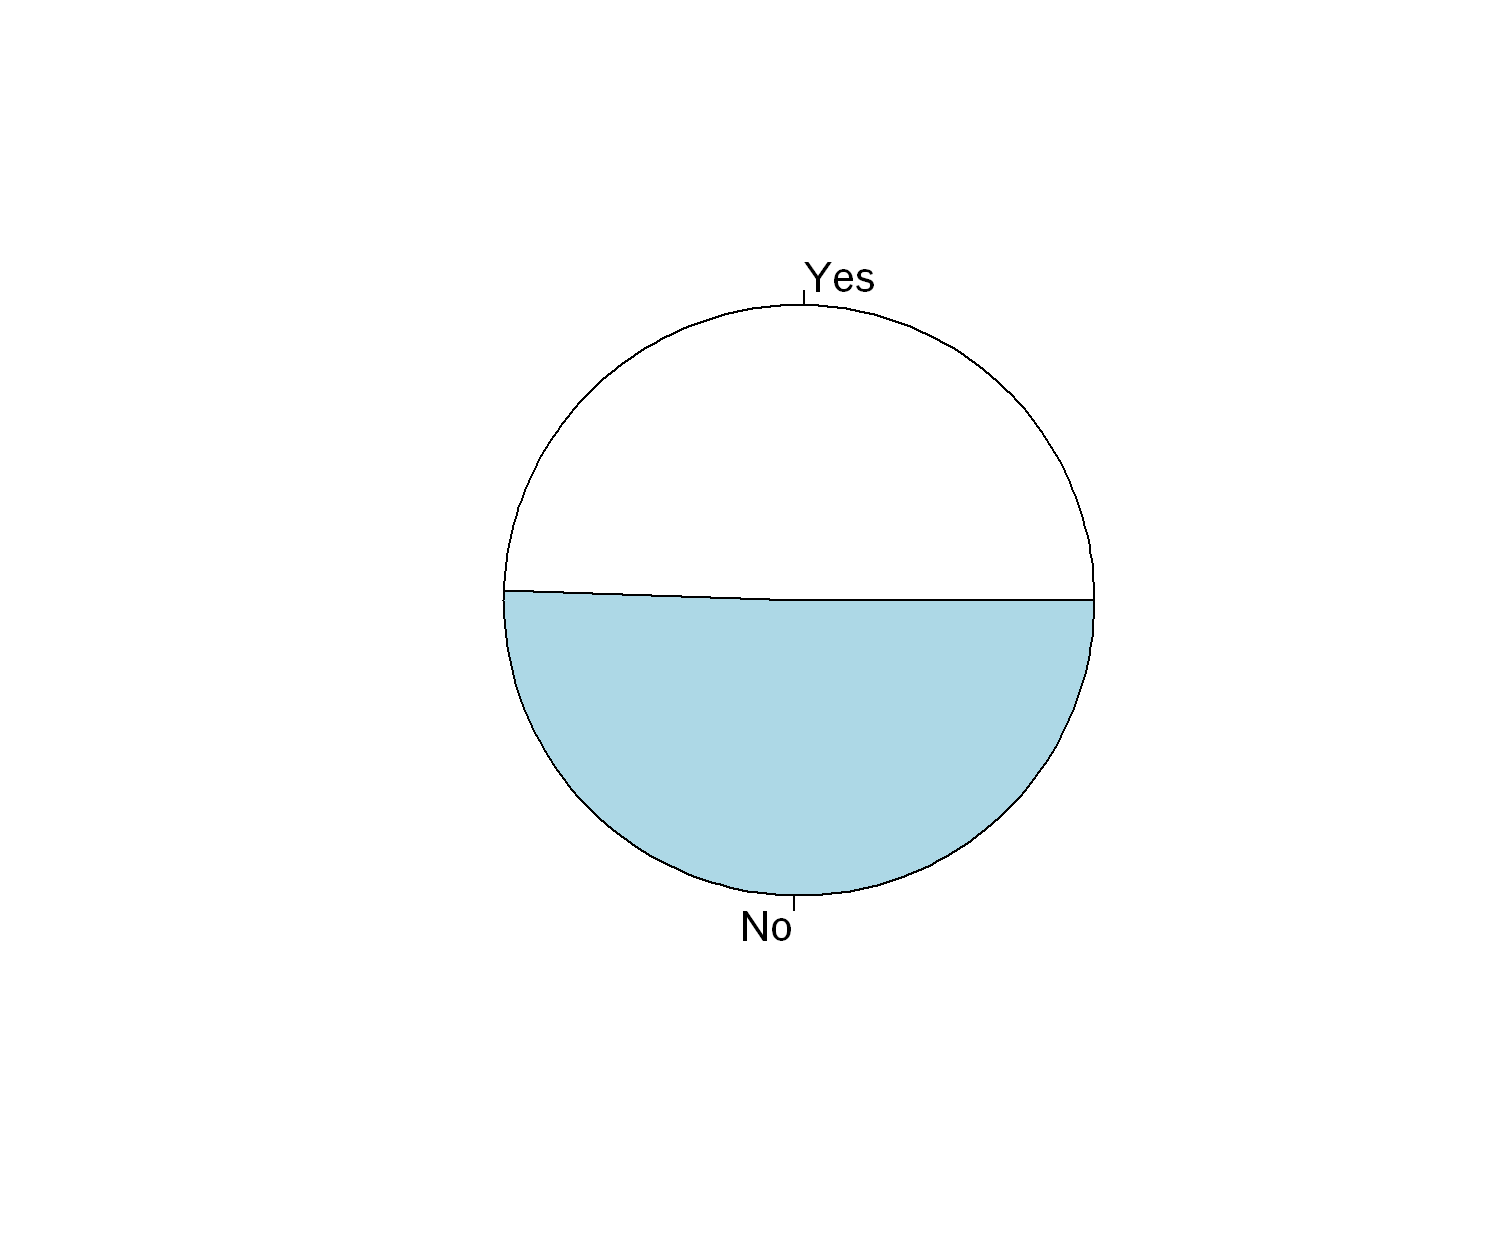

In [6]:
par(bg = "white")
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 250)


pie( x      = horas.extracurricular[, N], 
     labels = c("Yes", "No"))

Correlação entre a variavel numerica e binaria. Performance Index e Atv. Extracurricular possui alta correlação|associação?

In [7]:
studentPeformance[, 
    horas.extracurricular.bin := as.numeric(
        factor(studentPeformance$`Extracurricular Activities`)
        )
    ]
head(studentPeformance,n = 3)

Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index,horas.extracurricular.bin
<int>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>
7,99,Yes,9,1,91,2
4,82,No,4,2,65,1
8,51,Yes,7,2,45,2


In [8]:
# Usando a correlação de peason
cor(
    studentPeformance$`Performance Index`, studentPeformance$horas.extracurricular.bin,
    method = c("pearson")
)

[1] 0.02452495

> Possuem uma baixa correlação, mas verei outro metodo

In [9]:
# PointBisserl
biserial.cor(
    x = studentPeformance$`Performance Index`,
    y = studentPeformance$horas.extracurricular.bin
)

[1] -0.02452495

> Poderia remover essa varivel do modelo, contudo, vou utilizar todos e verificar por meio de teste de hipotese os coeficiente com significancia

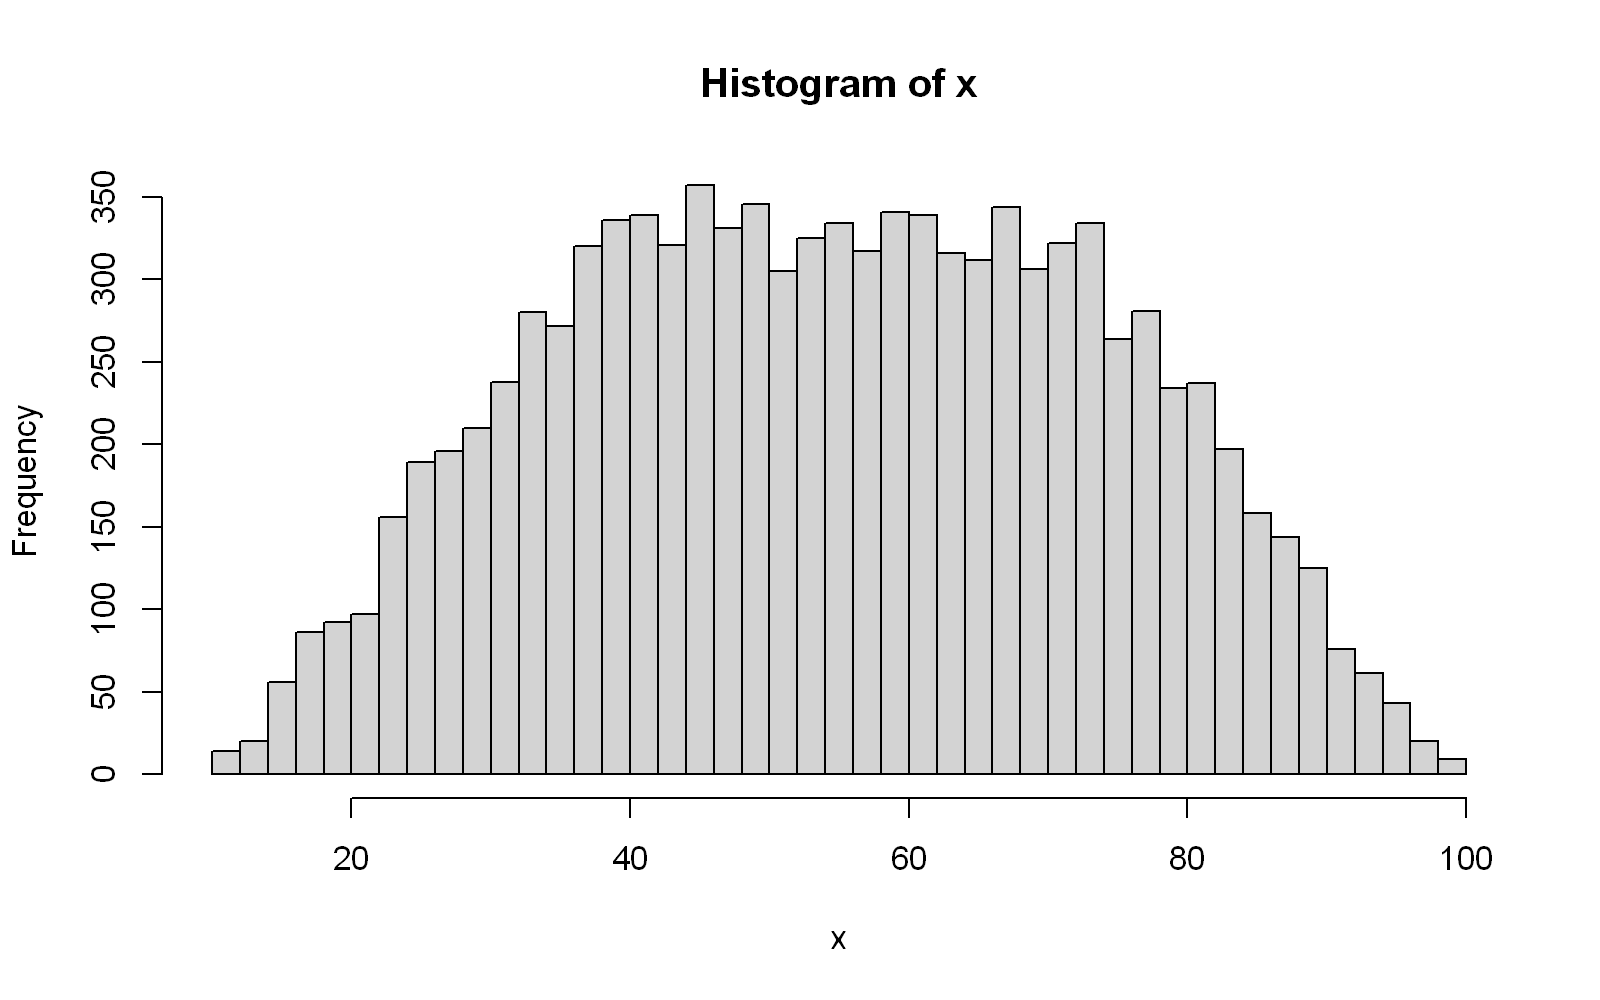

In [10]:
# Verificando a distribuição dos dados na hora de estudo
par(bg = "white")
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 200)

x = studentPeformance$`Performance Index`
hist(x, 40)

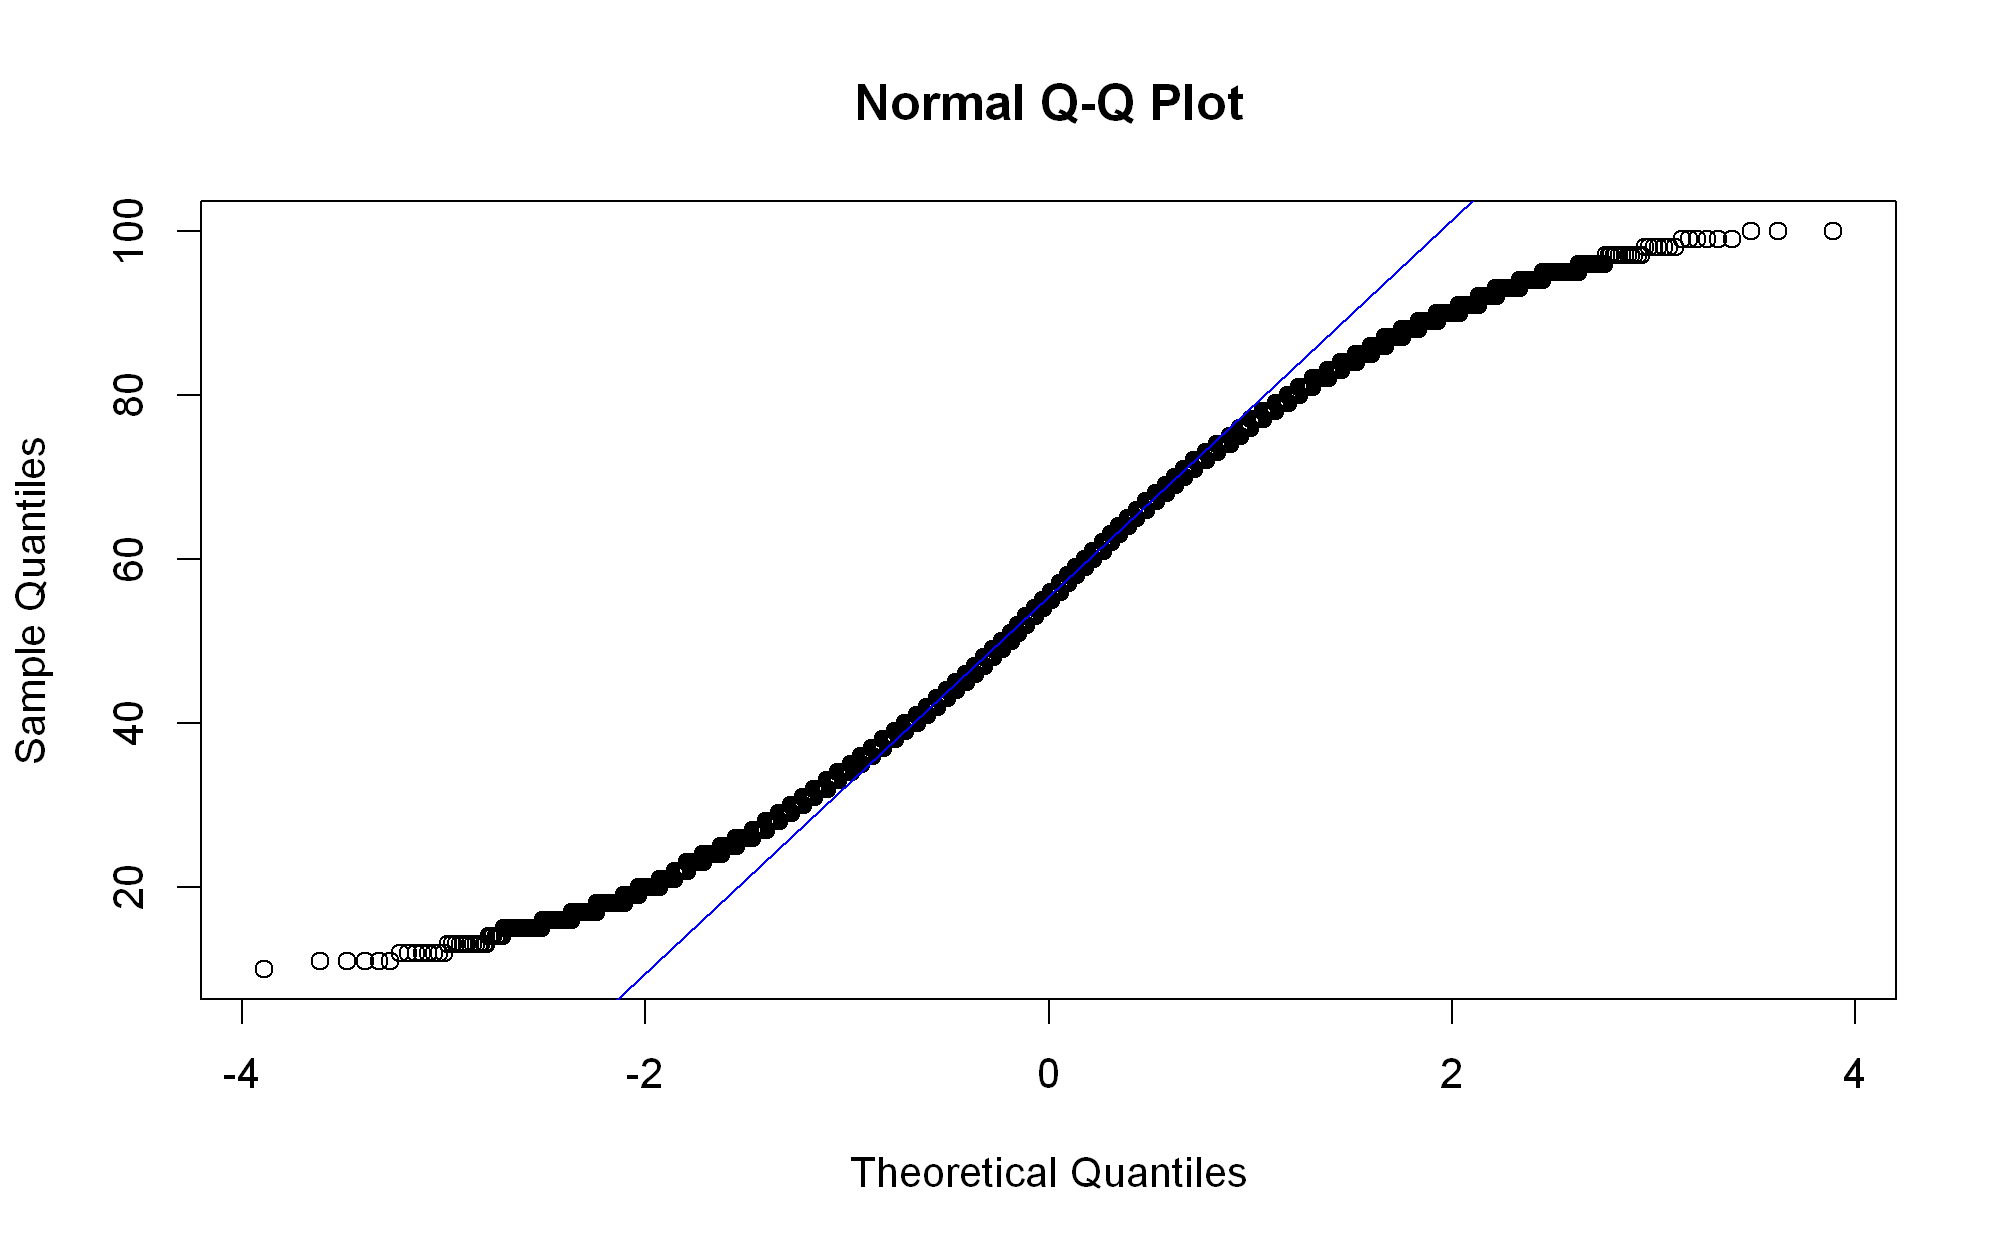

In [18]:
par(bg = "white")
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 250)

qqnorm(x)
qqline(x, col = "blue")

In [12]:
ks.test(x, "pnorm",  mean = mean(x), sd = sd(x))

Warning message in ks.test.default(x, "pnorm", mean = mean(x), sd = sd(x)):
"não devem existir empates no teste de Kolmogorov-Smirnov de apenas uma amostra"



	Asymptotic one-sample Kolmogorov-Smirnov test

data:  x
D = 0.045526, p-value < 2.2e-16
alternative hypothesis: two-sided


> p-valor não é maior 0.05 de significancia, dados não seguem um distribuição normal

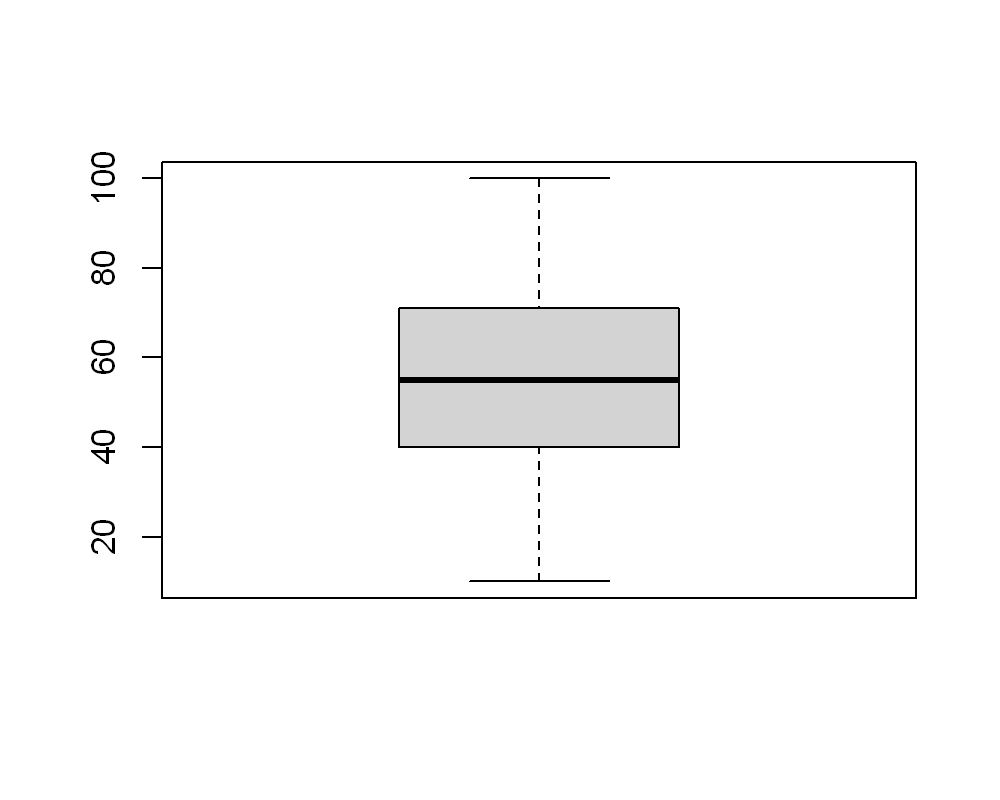

In [67]:
par(bg = "white")
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 200)
boxplot(x)

> Não há outliers na variavel alvo

In [45]:
# Verificando performane média de alunos em relação a horas de estudo

perfomance.hora = studentPeformance[, 
    mean(`Performance Index`), by = "Hours Studied"
    ]


# Modificando a coluna horas estudadas
perfomance.hora[
    , `Hours Studied` := paste("Horas", as.character(`Hours Studied`), sep=" ")
]

# Arrendodando
perfomance.hora[
    , V1 := round(x = V1, digits = 2)
]

perfomance.hora

Hours Studied,V1
<chr>,<dbl>
Horas 7,60.23
Horas 4,52.72
Horas 8,64.21
Horas 5,55.52
Horas 3,49.78
Horas 6,58.49
Horas 2,46.43
Horas 1,44.12
Horas 9,65.73


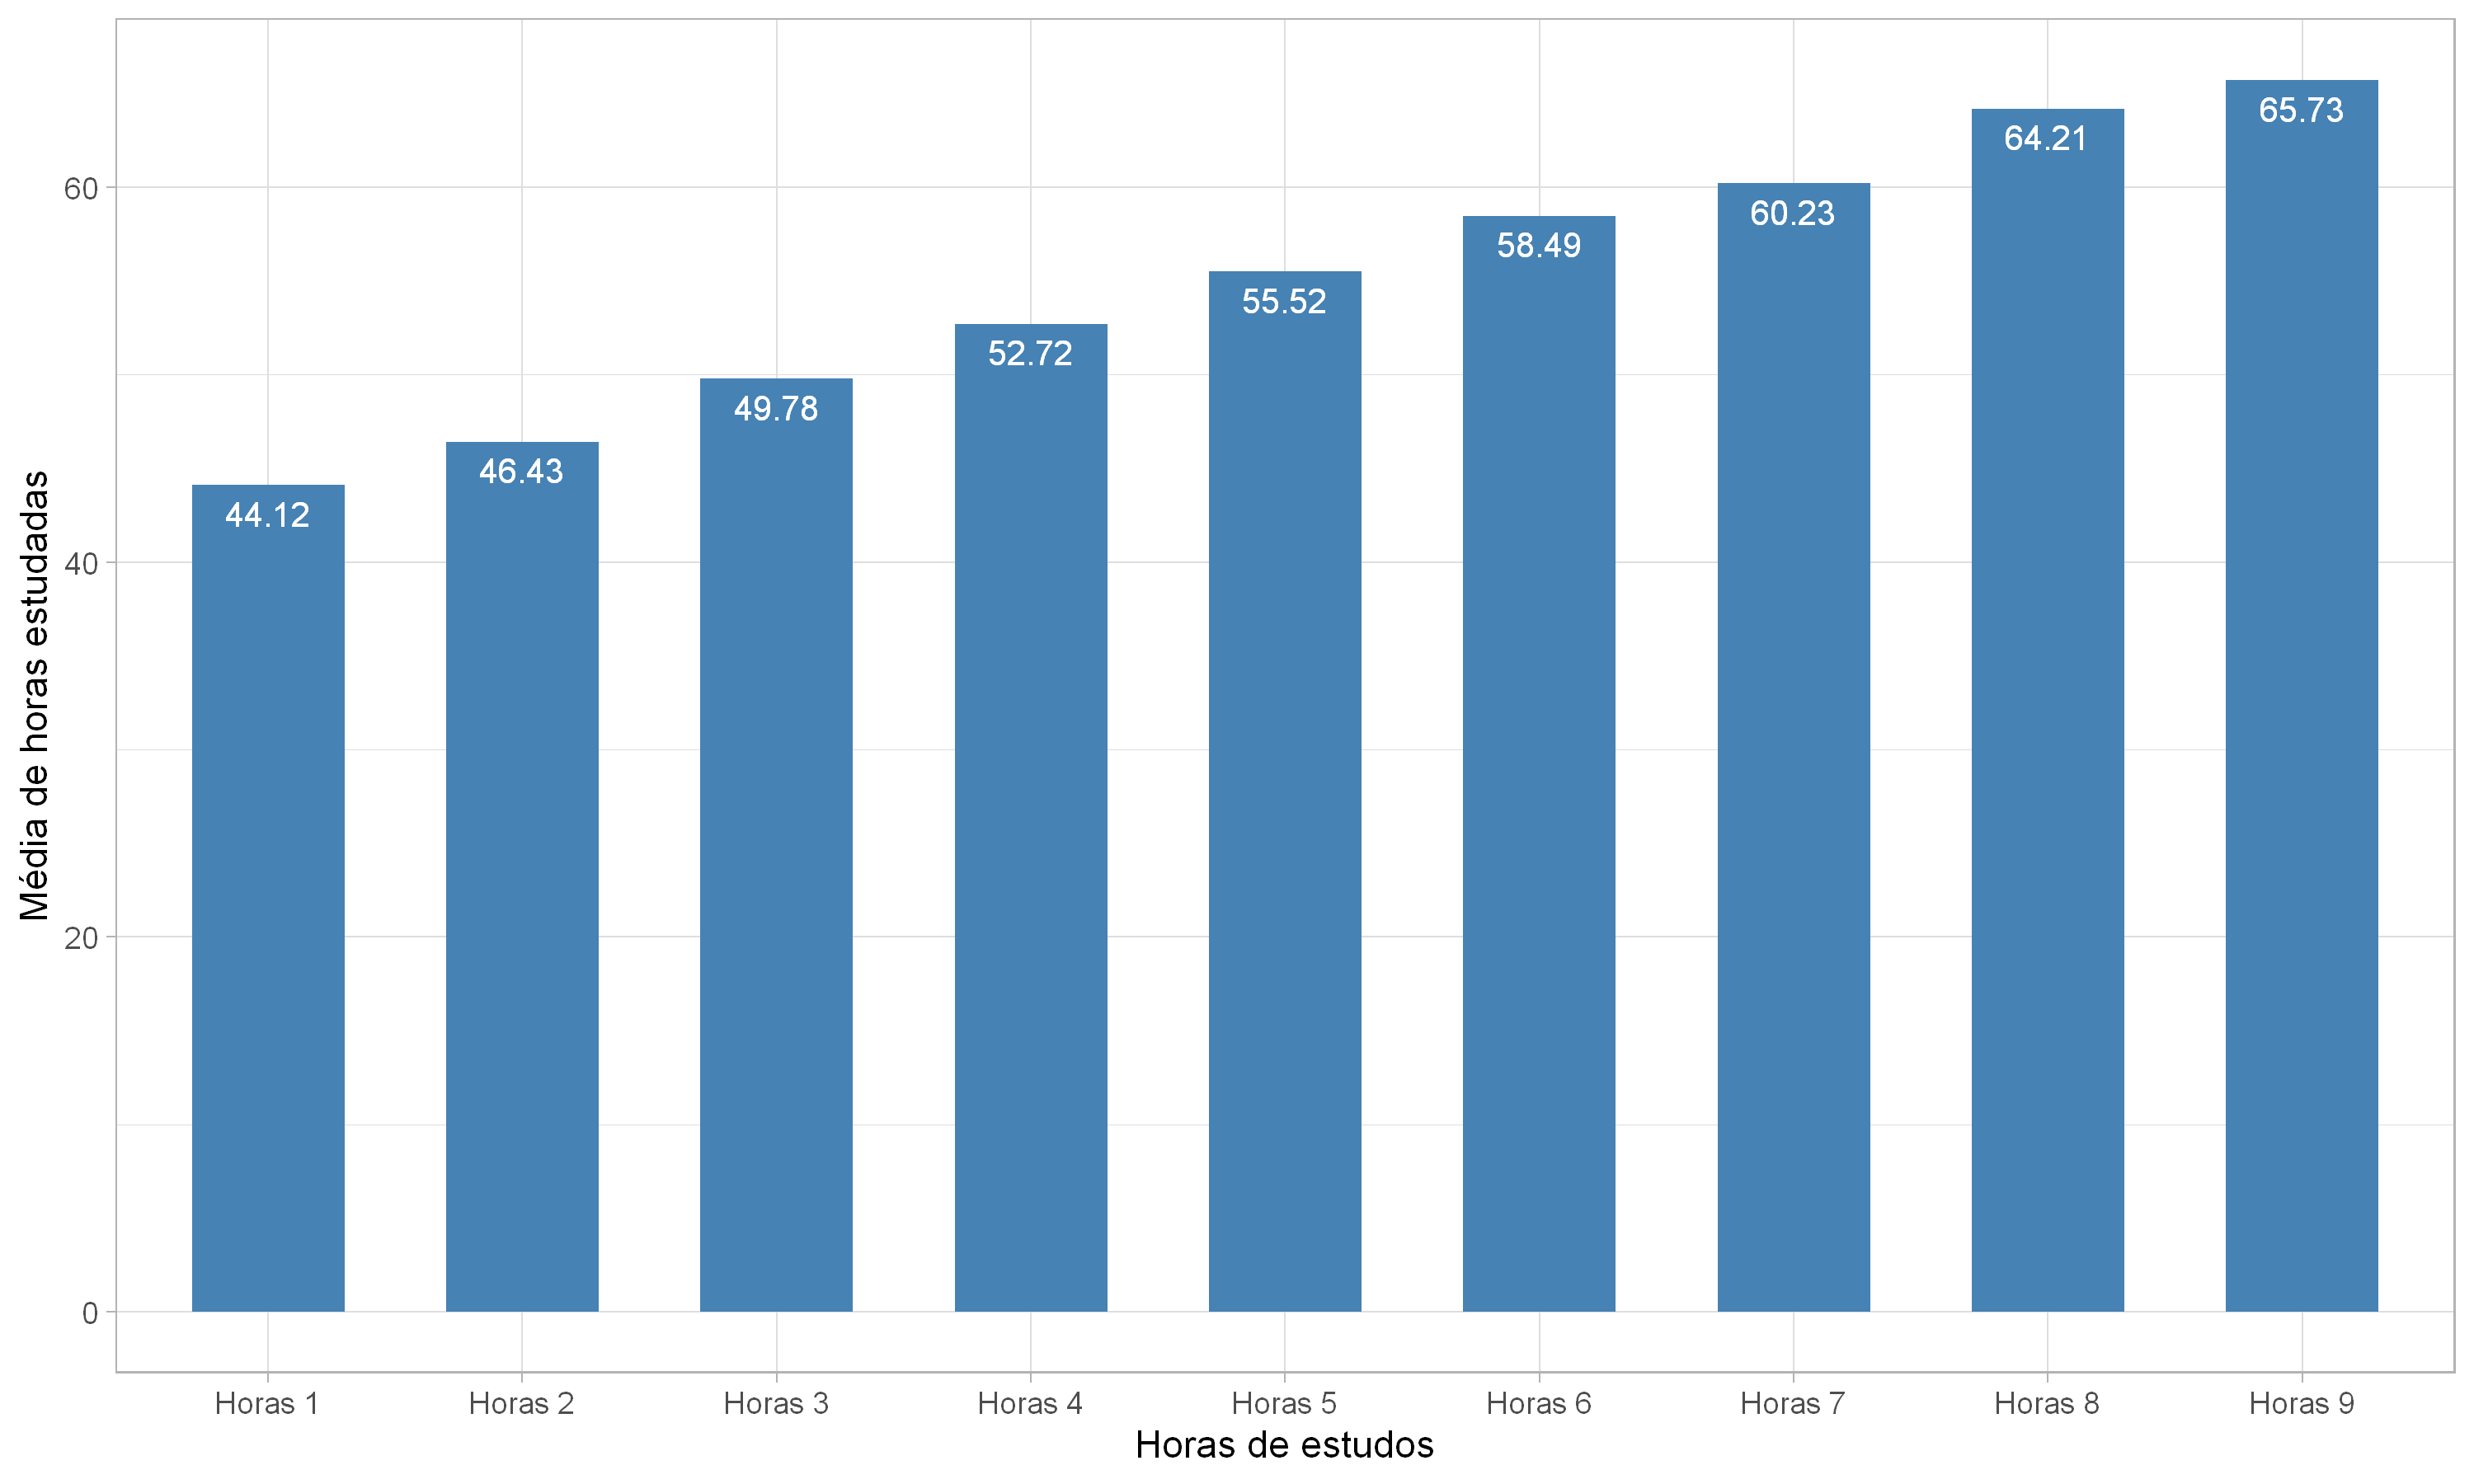

In [80]:
par(bg = "white")
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 300)


ggplot(
    perfomance.hora, aes(x = `Hours Studied`, y = V1)
    ) + 
    geom_bar( stat = "identity", width = 0.6, fill = "steelblue") +
    geom_text(aes(label=V1), vjust=1.6, color="white", size=3.5) +
    labs(
        x = "Horas de estudos",
        y = "Média de horas estudadas"
    ) +
    theme_light()

> Há um tedencia de aumento 

Modelo Regressão Multipla R

In [71]:
perfomance = fread(input = "C:\\Users\\mateu\\Documents\\MEGA\\Projetos-git\\DataAnalysisWith-R\\datasets\\StudentPerformance\\Student_Performance.csv")
head(perfomance,n = 5)

Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
<int>,<int>,<chr>,<int>,<int>,<dbl>
7,99,Yes,9,1,91
4,82,No,4,2,65
8,51,Yes,7,2,45
5,52,Yes,5,2,36
7,75,No,8,5,66


In [81]:
model_ = lm(`Performance Index`~., data = perfomance)

In [88]:
model_


Call:
lm(formula = `Performance Index` ~ ., data = perfomance)

Coefficients:
                       (Intercept)                     `Hours Studied`  
                          -34.0756                              2.8530  
                 `Previous Scores`     `Extracurricular Activities`Yes  
                            1.0184                              0.6129  
                     `Sleep Hours`  `Sample Question Papers Practiced`  
                            0.4806                              0.1938  


In [83]:
summary(model_)


Call:
lm(formula = `Performance Index` ~ ., data = perfomance)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.6333 -1.3684 -0.0311  1.3556  8.7932 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        -34.075588   0.127143 -268.01   <2e-16 ***
`Hours Studied`                      2.852982   0.007873  362.35   <2e-16 ***
`Previous Scores`                    1.018434   0.001175  866.45   <2e-16 ***
`Extracurricular Activities`Yes      0.612898   0.040781   15.03   <2e-16 ***
`Sleep Hours`                        0.480560   0.012022   39.97   <2e-16 ***
`Sample Question Papers Practiced`   0.193802   0.007110   27.26   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.038 on 9994 degrees of freedom
Multiple R-squared:  0.9888,	Adjusted R-squared:  0.9887 
F-statistic: 1.757e+05 on 5 and 9994 DF,  p-value: < 2.2e-16


> Todos os parametros do modelo são **significativos** pois  maior os p_valor $\=<$ nivel de significancia

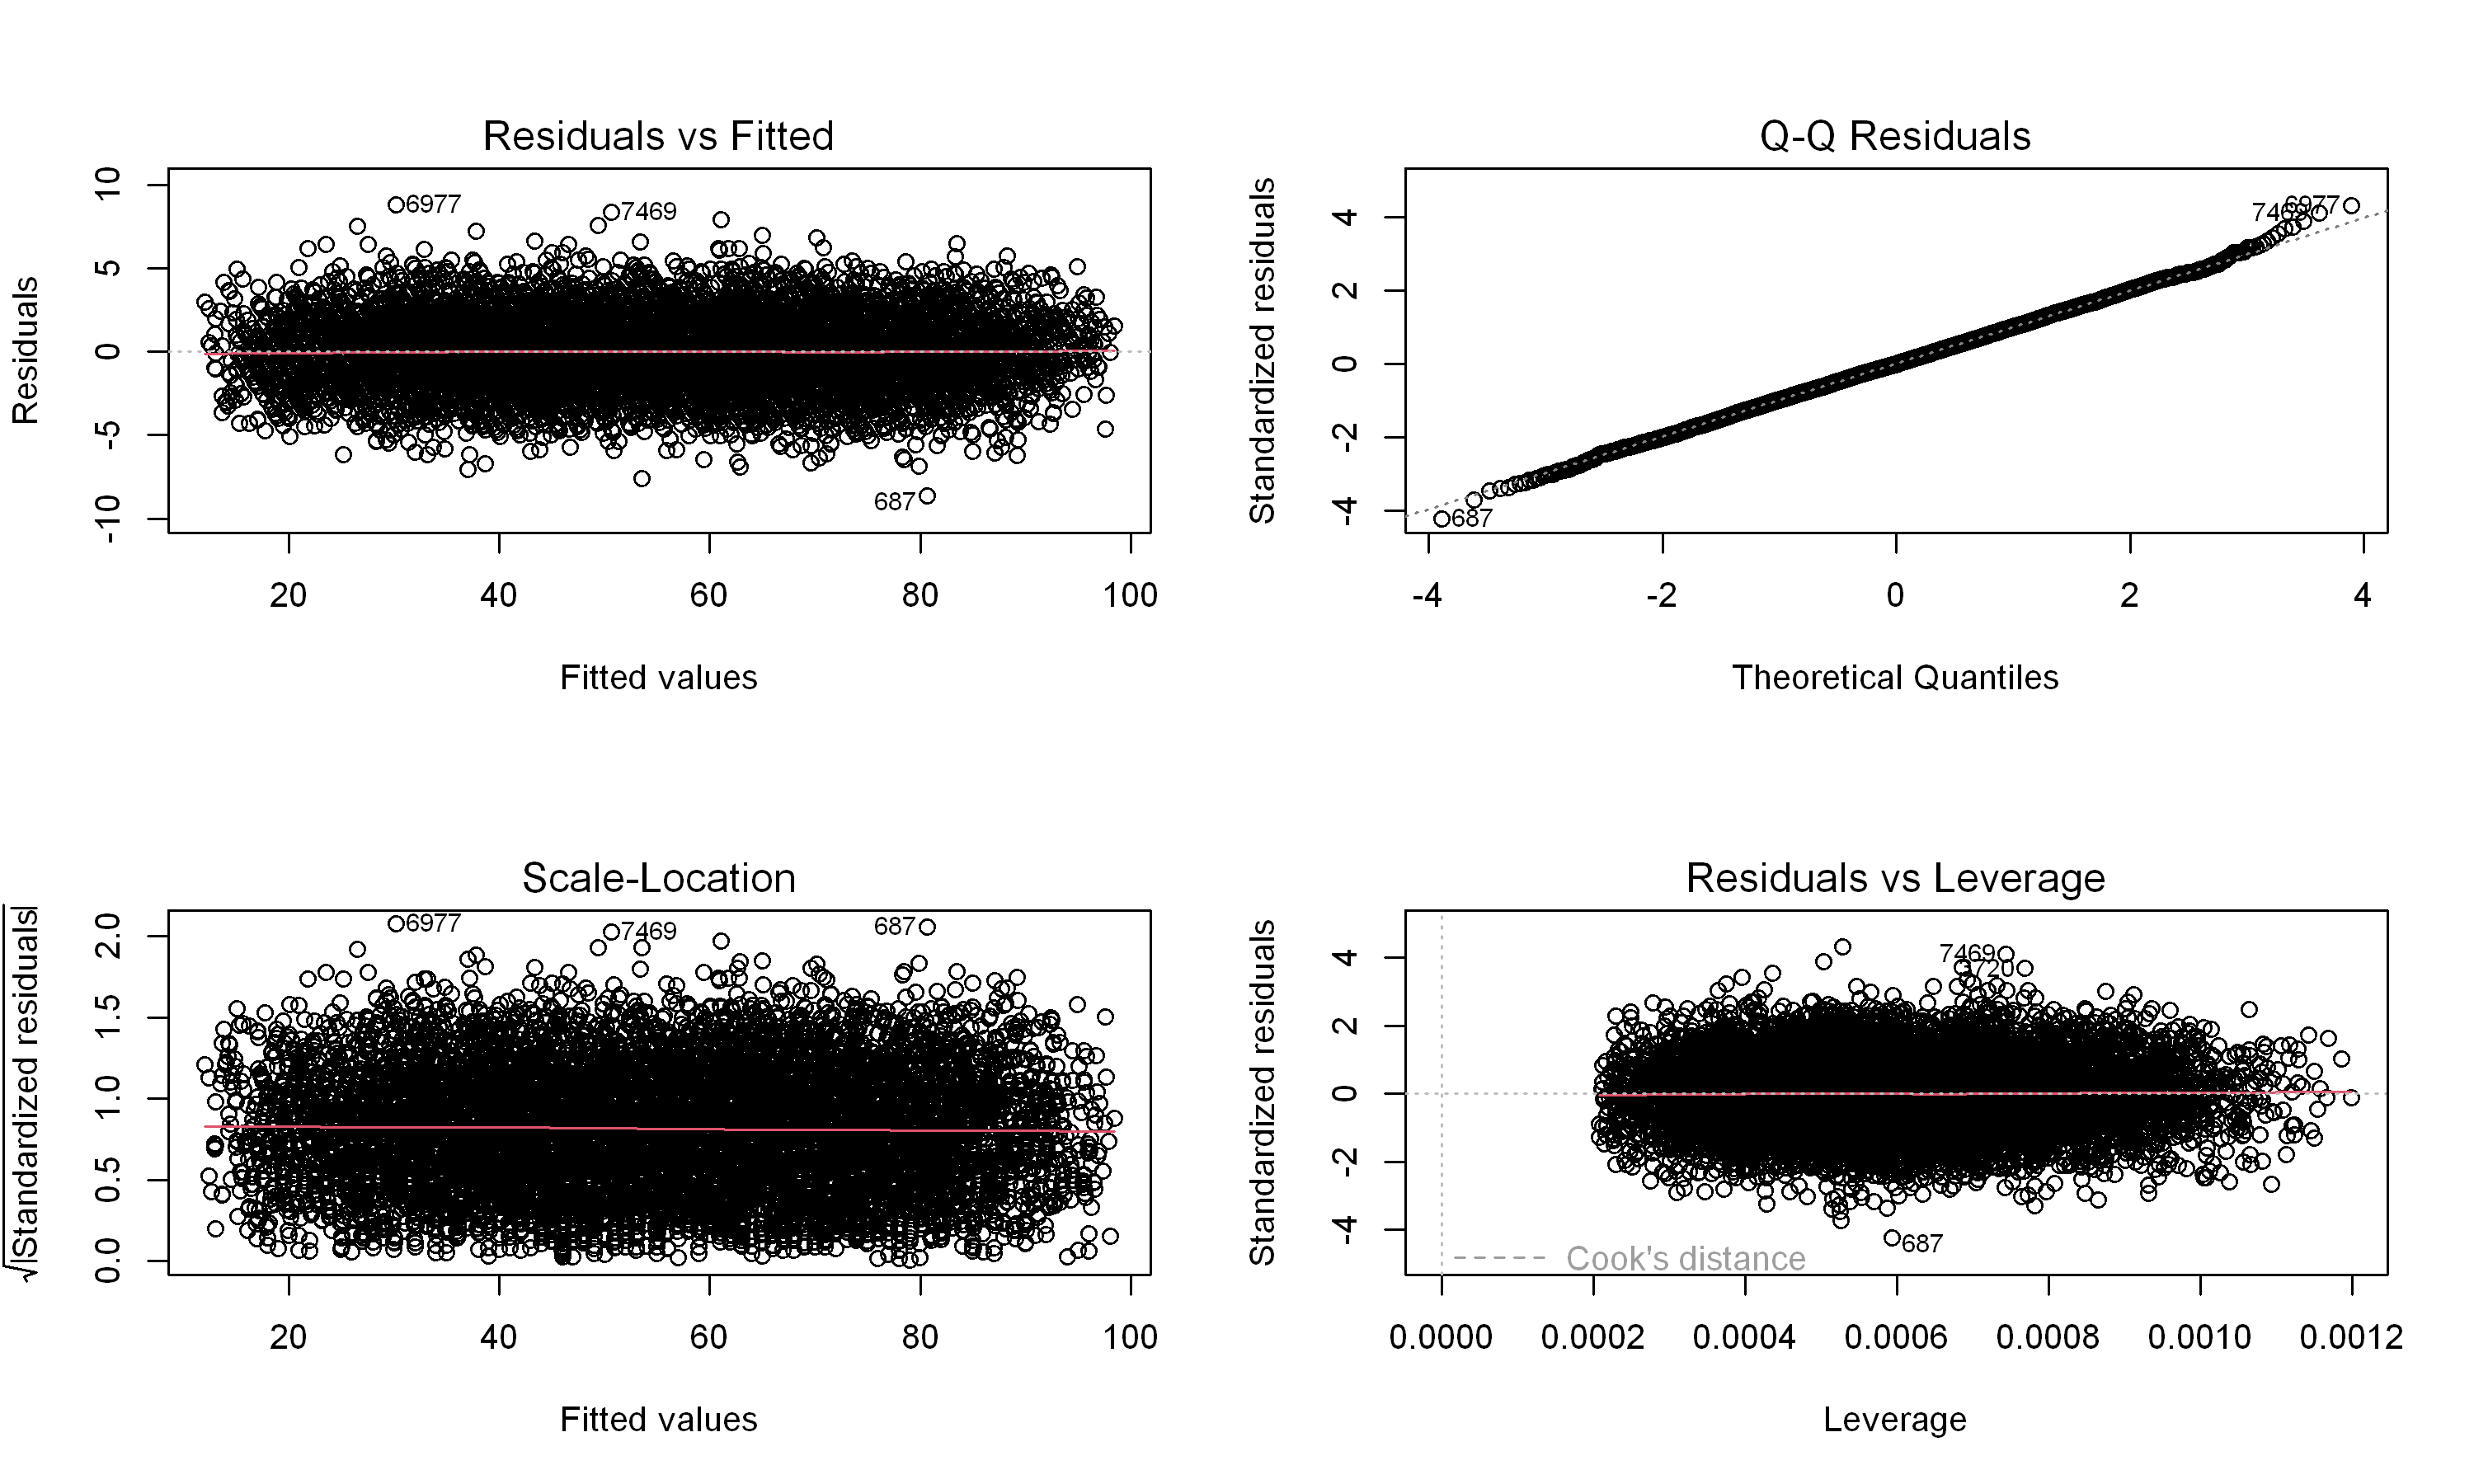

In [85]:
par(mfrow = c(2, 2), bg = "white")
plot(model_)

In [89]:
confint(model_)

,2.5 %,97.5 %
(Intercept),-34.3248136,-33.8263626
`Hours Studied`,2.8375484,2.8684157
`Previous Scores`,1.0161302,1.0207382
`Extracurricular Activities`Yes,0.5329596,0.6928356
`Sleep Hours`,0.4569937,0.5041258
`Sample Question Papers Practiced`,0.1798645,0.2077397


> intervalo de confiança para os parametros do modelo